In [24]:
import bw2io as bi
import bw2data as bd
import bw2calc as bc
from bw_temporalis import easy_timedelta_distribution, TemporalisLCA

In [25]:
bd.projects.set_current('tictac')

In [26]:
bd.databases

Databases dictionary with 4 object(s):
	wind-example
	wind-example-2020
	wind-example-2035
	wind-example-2050

In [34]:
# Generate 2020 database
generated_electricity_over_lifetime = 1000 # Amount of electricity generated by a wind turbine over its lifetime in kWh
share_of_wind_in_electricity_mix = 0.3

bd.Database('wind-example-2020').write({
    ('wind-example-2020', "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "unit": "kilogram",
    },
    ('wind-example-2020', "coal"): {
        "type": "emission",
        "name": "coal",
        "unit": "kilogram",
    },
    ('wind-example-2020', 'electricity-mix'): {
        'name': 'Electricity mix',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example-2020', 'electricity-production-wind'),
                'amount': share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example-2020', 'electricity-production-coal'),
                'amount': 1-share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
        ]
    },
    ('wind-example-2020', 'electricity-production-coal'): {
        'name': 'Electricity production, coal',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example-2020', 'coal'),
                'amount': 1,
                'type': 'biosphere',
            },
            {
                'input': ('wind-example-2020', 'CO2'),
                'amount': 1,
                'type': 'biosphere',
            },
        ]
    },
    ('wind-example-2020', 'electricity-production-wind'): {
        'name': 'Electricity production, wind',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example-2020', 'electricity-production-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example-2020', 'wind-turbine-construction'),
                'amount': 1/generated_electricity_over_lifetime,
                'type': 'technosphere',
                'temporal_distribution': easy_timedelta_distribution(
                    start=-5,
                    end=0,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=6,
                ),
            },
            # maybe add maintenance, oil changes, ...
        ]
    },
    ('wind-example-2020', 'wind-turbine-construction'): {
        'name': 'Wind turbine construction',
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example-2020', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'production'
            },
            {
                'input': ('wind-example-2020', 'electricity-mix'),
                'amount': 1,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example-2020', 'eol-wind'),
                'amount': 1,
                'type': 'technosphere',
                # 'temporal_distribution': easy_timedelta_distribution(
                #     start=0,
                #     end=20,
                #     resolution="Y",  # M for months, Y for years, etc.
                #     steps=10,
                # ),
            },
            # aggregate the rest to direct co2 emissions
            {
                'input': ('wind-example-2020', 'CO2'),
                'amount': 1,
                'type': 'biosphere',
            }
        ]
    },
    ('wind-example-2020', 'eol-wind'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example-2020', 'eol-wind'),
                'amount': 1,
                'type': 'production',
            },
            # aggregate the rest to direct co2 emissions
            {
                'input': ('wind-example-2020', 'CO2'),
                'amount': 1,
                'type': 'biosphere',
            }
        ]
    },
})

Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 7/7 [00:00<?, ?it/s]

Vacuuming database 


In [28]:
# Generate 2035 database

generated_electricity_over_lifetime = 1000 # Amount of electricity generated by a wind turbine over its lifetime in kWh
share_of_wind_in_electricity_mix = 0.5

bd.Database('wind-example-2035').write({
    ('wind-example-2035', "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "unit": "kilogram",
    },
    ('wind-example-2035', "coal"): {
        "type": "emission",
        "name": "coal",
        "unit": "kilogram",
    },
    ('wind-example-2035', 'electricity-mix'): {
        'name': 'Electricity mix',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example-2035', 'electricity-production-wind'),
                'amount': share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example-2035', 'electricity-production-coal'),
                'amount': 1-share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
        ]
    },
    ('wind-example-2035', 'electricity-production-coal'): {
        'name': 'Electricity production, coal',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example-2035', 'coal'),
                'amount': 1,
                'type': 'biosphere',
            },
            {
                'input': ('wind-example-2035', 'CO2'),
                'amount': 1,
                'type': 'biosphere',
            },
        ]
    },
    ('wind-example-2035', 'electricity-production-wind'): {
        'name': 'Electricity production, wind',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example-2035', 'electricity-production-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example-2035', 'wind-turbine-construction'),
                'amount': 1/generated_electricity_over_lifetime,
                'type': 'technosphere',
                'temporal_distribution': easy_timedelta_distribution(
                    start=-5,
                    end=0,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=6,
                ),
            },
            # maybe add maintenance, oil changes, ...
        ]
    },
    ('wind-example-2035', 'wind-turbine-construction'): {
        'name': 'Wind turbine construction',
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example-2035', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'production'
            },
            {
                'input': ('wind-example-2035', 'electricity-mix'),
                'amount': 1,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example-2035', 'eol-wind'),
                'amount': 1,
                'type': 'technosphere',
                # 'temporal_distribution': easy_timedelta_distribution(
                #     start=0,
                #     end=20,
                #     resolution="Y",  # M for months, Y for years, etc.
                #     steps=10,
                # ),
            },
            # aggregate the rest to direct co2 emissions
            {
                'input': ('wind-example-2035', 'CO2'),
                'amount': 1,
                'type': 'biosphere',
            }
        ]
    },
    ('wind-example-2035', 'eol-wind'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example-2035', 'eol-wind'),
                'amount': 1,
                'type': 'production',
            },
            # aggregate the rest to direct co2 emissions
            {
                'input': ('wind-example-2035', 'CO2'),
                'amount': 1,
                'type': 'biosphere',
            }
        ]
    },
})

Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 7/7 [00:00<?, ?it/s]

Vacuuming database 


In [29]:
# Generate 2050 database

generated_electricity_over_lifetime = 1000 # Amount of electricity generated by a wind turbine over its lifetime in kWh
share_of_wind_in_electricity_mix = 0.7

bd.Database('wind-example-2050').write({
    ('wind-example-2050', "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "unit": "kilogram",
    },
    ('wind-example-2050', "coal"): {
        "type": "emission",
        "name": "coal",
        "unit": "kilogram",
    },
    ('wind-example-2050', 'electricity-mix'): {
        'name': 'Electricity mix',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example-2050', 'electricity-production-wind'),
                'amount': share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example-2050', 'electricity-production-coal'),
                'amount': 1-share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
        ]
    },
    ('wind-example-2050', 'electricity-production-coal'): {
        'name': 'Electricity production, coal',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example-2050', 'coal'),
                'amount': 1,
                'type': 'biosphere',
            },
            {
                'input': ('wind-example-2050', 'CO2'),
                'amount': 1,
                'type': 'biosphere',
            },
        ]
    },
    ('wind-example-2050', 'electricity-production-wind'): {
        'name': 'Electricity production, wind',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example-2050', 'electricity-production-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example-2050', 'wind-turbine-construction'),
                'amount': 1/generated_electricity_over_lifetime,
                'type': 'technosphere',
                'temporal_distribution': easy_timedelta_distribution(
                    start=-5,
                    end=0,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=6,
                ),
            },
            # maybe add maintenance, oil changes, ...
        ]
    },
    ('wind-example-2050', 'wind-turbine-construction'): {
        'name': 'Wind turbine construction',
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example-2050', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'production'
            },
            {
                'input': ('wind-example-2050', 'electricity-mix'),
                'amount': 1,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example-2050', 'eol-wind'),
                'amount': 1,
                'type': 'technosphere',
                # 'temporal_distribution': easy_timedelta_distribution(
                #     start=0,
                #     end=20,
                #     resolution="Y",  # M for months, Y for years, etc.
                #     steps=10,
                # ),
            },
            # aggregate the rest to direct co2 emissions
            {
                'input': ('wind-example-2050', 'CO2'),
                'amount': 1,
                'type': 'biosphere',
            }
        ]
    },
    ('wind-example-2050', 'eol-wind'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example-2050', 'eol-wind'),
                'amount': 1,
                'type': 'production',
            },
            # aggregate the rest to direct co2 emissions
            {
                'input': ('wind-example-2050', 'CO2'),
                'amount': 1,
                'type': 'biosphere',
            }
        ]
    },
})

Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 7/7 [00:00<?, ?it/s]

Vacuuming database 


In [37]:
bd.Method(("GWP", "wind-example-2020")).write([
    (('wind-example-2020', "CO2"), 1),
])

In [40]:
lca = bc.LCA({('wind-example-2020', 'electricity-production-wind'): 1}, ("GWP", "wind-example-2020"))
lca.lci()
lca.lcia()
lca.score

0.0027008103595007197

# Temporalis

In [7]:
tlca = TemporalisLCA(lca)

Starting graph traversal
Calculation count: 5


In [10]:
tl = tlca.build_timeline()

In [11]:
tl_df = tl.build_dataframe()

In [12]:
tl_df

,date,amount,flow,activity
0,2018-10-11 09:20:59,0.000083,1,6
1,2018-10-11 09:20:59,0.000083,1,7
2,2019-10-11 15:10:11,0.000083,1,6
3,2019-10-11 15:10:11,0.000083,1,7
4,2020-10-10 20:59:23,0.000083,1,6
5,2020-10-10 20:59:23,0.000083,1,7
6,2021-10-11 02:48:35,0.000083,1,6
7,2021-10-11 02:48:35,0.000083,1,7
8,2022-10-11 08:37:47,0.000083,1,6
9,2022-10-11 08:37:47,0.000083,1,7


<Axes: xlabel='date', ylabel='amount'>

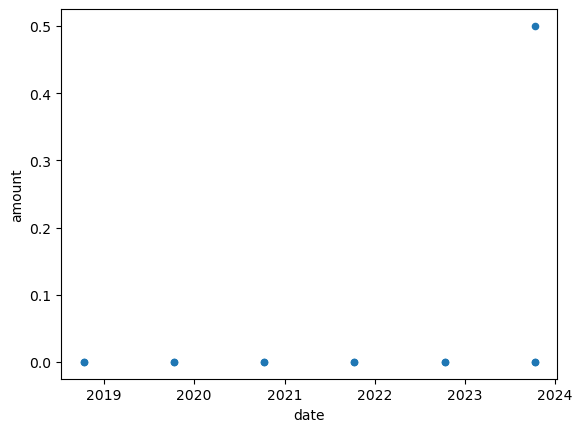

In [13]:
tl.df.plot(x="date", y="amount", kind="scatter")

In [14]:
tl_dt = tl.add_metadata_to_dataframe(database_labels=["wind-example"], fields=['name', 'unit', 'location', 'categories'])

In [15]:
tl_dt

,date,amount,flow,activity,activity_name,activity_unit,flow_name,flow_unit
0,2018-10-11 09:20:59,0.000083,1,6,Wind turbine construction,unit,carbon dioxide,kilogram
1,2018-10-11 09:20:59,0.000083,1,7,"End-of-life, wind turbine",unit,carbon dioxide,kilogram
2,2019-10-11 15:10:11,0.000083,1,6,Wind turbine construction,unit,carbon dioxide,kilogram
3,2019-10-11 15:10:11,0.000083,1,7,"End-of-life, wind turbine",unit,carbon dioxide,kilogram
4,2020-10-10 20:59:23,0.000083,1,6,Wind turbine construction,unit,carbon dioxide,kilogram
5,2020-10-10 20:59:23,0.000083,1,7,"End-of-life, wind turbine",unit,carbon dioxide,kilogram
6,2021-10-11 02:48:35,0.000083,1,6,Wind turbine construction,unit,carbon dioxide,kilogram
7,2021-10-11 02:48:35,0.000083,1,7,"End-of-life, wind turbine",unit,carbon dioxide,kilogram
8,2022-10-11 08:37:47,0.000083,1,6,Wind turbine construction,unit,carbon dioxide,kilogram
9,2022-10-11 08:37:47,0.000083,1,7,"End-of-life, wind turbine",unit,carbon dioxide,kilogram


In [16]:
tl_dt.date

0    2018-10-11 09:20:59
1    2018-10-11 09:20:59
2    2019-10-11 15:10:11
3    2019-10-11 15:10:11
4    2020-10-10 20:59:23
5    2020-10-10 20:59:23
6    2021-10-11 02:48:35
7    2021-10-11 02:48:35
8    2022-10-11 08:37:47
9    2022-10-11 08:37:47
10   2023-10-11 14:26:59
11   2023-10-11 14:26:59
12   2023-10-11 14:26:59
Name: date, dtype: datetime64[s]